Connecting to PostgreSQL data warehouse.

In [3]:
import psycopg2
import os
from dotenv import load_dotenv


load_dotenv()

connection = psycopg2.connect(
    database="data_analysis",
    user="postgres",
    password=os.environ["PASSWORD"]
)

Initial df setup.

In [4]:
import pandas as pd


query = """
    SELECT 
        dg.id AS app_id,
        fg.online,
        COALESCE (fg.price, dg.price) AS current_price,
        COALESCE (fg.discount, 0) AS discount,
        dd.date,
        dg.required_age,
        dg.achievements,
        dg.positive_ratings,
        dg.negative_ratings,
        dg.median_playtime,
        dg.owners,
        dg.price,
        fri.count_reviews AS current_count_reviews,
        fri.total_review AS current_total_review,
        dt.name AS tag,
        dp.name AS platform
    FROM main.fact_game fg
    JOIN main.dim_date dd ON dd.id = fg.dim_date_id
    JOIN main.dim_game dg ON dg.id = fg.dim_game_id
    JOIN (
        SELECT dim_game_id, 
            dim_date_id, 
            COUNT(*) AS count_reviews, 
            COUNT(CASE WHEN recommended = TRUE THEN 1 END) - COUNT(CASE WHEN recommended = FALSE THEN 0 END) AS total_review
        FROM main.fact_review fr
        GROUP BY dim_game_id, dim_date_id
    ) fri ON fri.dim_game_id = fg.dim_game_id AND fri.dim_date_id = fg.dim_date_id
    JOIN main.dim_tag_game dtg ON fg.dim_game_id = dtg.dim_game_id
    JOIN main.dim_tag dt ON dt.id = dtg.dim_tag_id
    JOIN main.dim_platform_game dpg ON fg.dim_game_id = dpg.dim_game_id
    JOIN main.dim_platform dp ON dp.id = dpg.dim_platform_id"""

df = pd.read_sql(query, connection)

C:\Users\User\AppData\Local\Temp\ipykernel_17872\1679522131.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Select target and features.

In [5]:
LAG = 30
ONLINE_LAGS = [30, 45, 60]

dummy_df = pd.get_dummies(df, columns=["tag", "platform"], prefix=["tag", "platform"])
dummy_df = dummy_df.groupby(["app_id", "date"]).agg("max").reset_index()

target = "online"
features = []

for lag in ONLINE_LAGS:
    dummy_df[f"online_lag_{lag}"] = dummy_df.groupby("app_id")["online"].shift(lag)
    features.append(f"online_lag_{lag}")

dummy_df[f"price_lag_{LAG}"] = dummy_df.groupby("app_id")["current_price"].shift(LAG)
dummy_df[f"count_reviews_lag_{LAG}"] = dummy_df.groupby("app_id")["current_count_reviews"].shift(LAG)
dummy_df[f"total_review_lag_{LAG}"] = dummy_df.groupby("app_id")["current_total_review"].shift(LAG)
dummy_df[f"discount_lag_{LAG}"] = dummy_df.groupby("app_id")["discount"].shift(LAG)

dummy_df.dropna(inplace=True)

dummy_df["date"] = pd.to_datetime(dummy_df["date"])
dummy_df["is_weekend"] = (dummy_df["date"].dt.dayofweek >= 5).astype(int)

features.extend([
    "achievements",
    "required_age",
    "median_playtime",
    "owners",
    "is_weekend",
    f"price_lag_{LAG}",
    f"count_reviews_lag_{LAG}",
    f"total_review_lag_{LAG}",
    f"discount_lag_{LAG}",
])

tag_columns = [col for col in dummy_df.columns if col.startswith("tag_")]
correlation_with_target = dummy_df[tag_columns + [target]].corr()[target]
top_tags = correlation_with_target[tag_columns].abs().sort_values(ascending=False).head(5)

for tag in top_tags.index:
    dummy_df[tag] = dummy_df[tag].astype(int)
    features.append(tag)

dummy_df["platform_count"] = dummy_df.filter(like="platform_").sum(axis=1)
features.append("platform_count")

Split into train and test data.

In [6]:
time_series_data = {}

for app_id, group in dummy_df.groupby("app_id"):
    constants_columns = [col for col in group.columns if group[col].nunique() == 1]
    non_constants_features = [feature for feature in features if feature not in constants_columns + ["price_lag_30", "discount_lag_30"]]
    group = group.drop(columns=constants_columns)

    group = group.sort_values("date")
    group = group.set_index("date").asfreq('D')

    all_data = group.fillna(method="ffill")

    group = group.dropna()
    train_data = group.iloc[:-LAG]
    test_data = group.iloc[-LAG:]
    
    time_series_data[app_id] = {"train": train_data, "test": test_data, "all": all_data}

dummy_df["date"] = pd.to_datetime(dummy_df["date"])
latest_date = dummy_df["date"].max()
cutoff_date = latest_date - pd.DateOffset(days=LAG)

train_df = dummy_df[dummy_df["date"] < cutoff_date]
test_df = dummy_df[dummy_df["date"] >= cutoff_date]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

C:\Users\User\AppData\Local\Temp\ipykernel_17872\233121274.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data = group.fillna(method="ffill")
C:\Users\User\AppData\Local\Temp\ipykernel_17872\233121274.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data = group.fillna(method="ffill")
C:\Users\User\AppData\Local\Temp\ipykernel_17872\233121274.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data = group.fillna(method="ffill")
C:\Users\User\AppData\Local\Temp\ipykernel_17872\233121274.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data = group.fillna(method="ffill")
C:\Users\User\AppData\Lo

Model XGBRegressor.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit


N_JOBS = -1
CV = TimeSeriesSplit()
SCORING = "neg_mean_absolute_percentage_error"

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.1, 1, 5],
}

grid_search = GridSearchCV(xgb.XGBRegressor(n_jobs=N_JOBS), param_grid=param_grid, scoring=SCORING, cv=CV, n_jobs=N_JOBS)
grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_) 
print("CV mean score:", -grid_search.best_score_ * 100)

y_pred = best_xgb_model.predict(X_train)
mape = mean_absolute_percentage_error(y_train, y_pred) * 100
print(f"Train MAPE: {mape}")

y_pred = best_xgb_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Test MAPE: {mape}")

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.8}
CV mean score: 72.14424729347229
Train MAPE: 37.90993690490723
Test MAPE: 37.884461879730225


Model LGMRegressor.

In [ ]:
from lightgbm import LGBMRegressor


param_grid = {
    'n_estimators': [50, 100, 150],             
    'learning_rate': [0.01, 0.05, 0.1],                
    'max_depth': [5, 7, 10],                     
    'num_leaves': [15, 31, 63],                      
    'min_child_samples': [10, 20],              
    'subsample': [0.8, 1.0],                     
    'colsample_bytree': [0.8, 1.0],            
    'reg_alpha': [0, 0.1, 1],                   
    'reg_lambda': [0.1, 1, 5],                 
}

grid_search = GridSearchCV(LGBMRegressor(n_jobs=N_JOBS), param_grid=param_grid, scoring=SCORING, cv=CV, n_jobs=N_JOBS)
grid_search.fit(X_train, y_train)

best_lgbm_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("CV mean score:", -grid_search.best_score_ * 100)

y_pred = best_lgbm_model.predict(X_train)
mape = mean_absolute_percentage_error(y_train, y_pred) * 100
print(f"Train MAPE: {mape}")

y_pred = best_lgbm_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Test MAPE: {mape}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1659
[LightGBM] [Info] Number of data points in the train set: 127284, number of used features: 18
[LightGBM] [Info] Start training from score 9304.290209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Model LinearSVR.

In [18]:
from sklearn.svm import LinearSVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFECV(LinearSVR())),
    ('svr', LinearSVR())
])

param_grid = {
    'svr__C': [0.01, 0.1, 1, 10, 100, 1000, 100000],
    'svr__epsilon': [0.01, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=CV, scoring=SCORING, n_jobs=N_JOBS)
grid_search.fit(X_train, y_train)

best_svr_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("CV mean score:", -grid_search.best_score_ * 100)

y_pred = best_svr_model.predict(X_train)
mape = mean_absolute_percentage_error(y_train, y_pred) * 100
print("Train MAPE:", mape)

y_pred = best_svr_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print("Test MAPE:", mape)

c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'svr__C': 1000, 'svr__epsilon': 0.01}
CV mean score: 54.500248212119715
Train MAPE: 39.33648304999537
Test MAPE: 39.249560514778


Model (S)ARIMA(X).

Stationarity is checked by auto_arima, checking if seasonal.

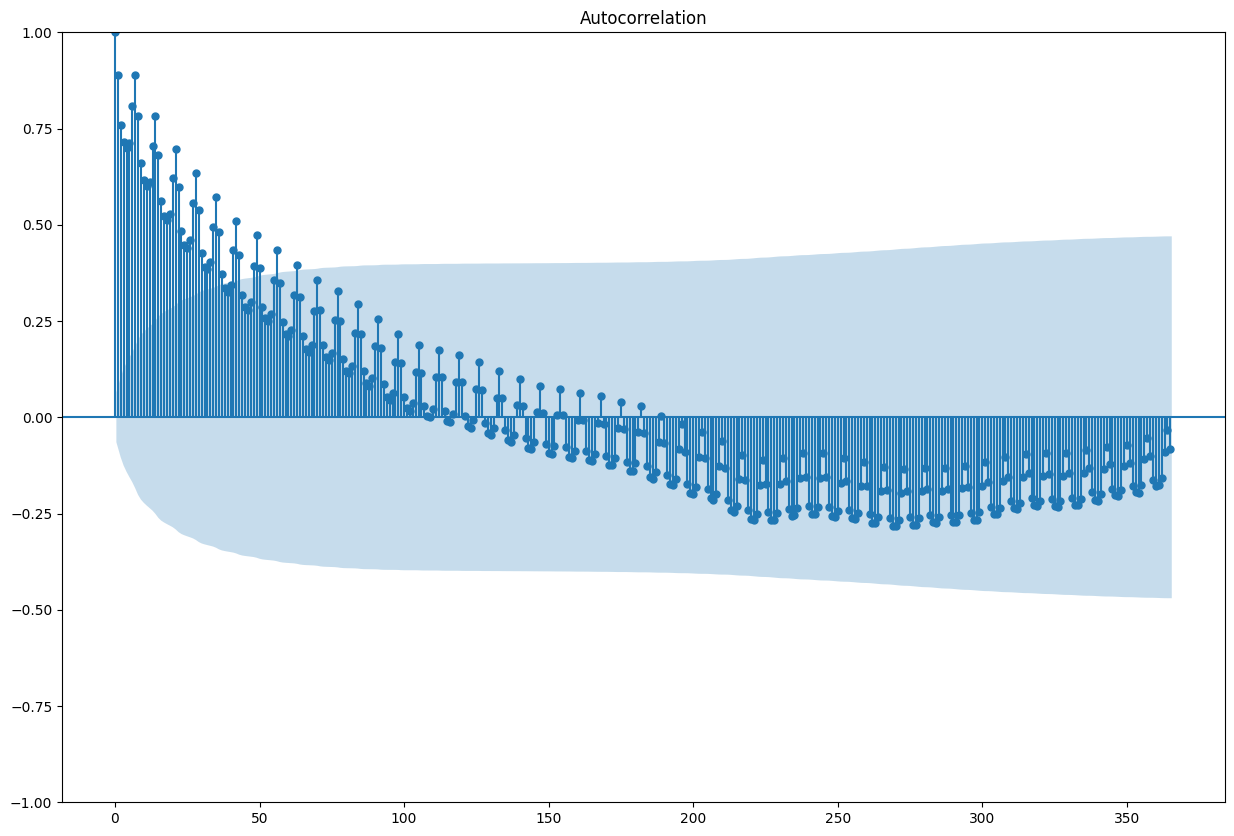

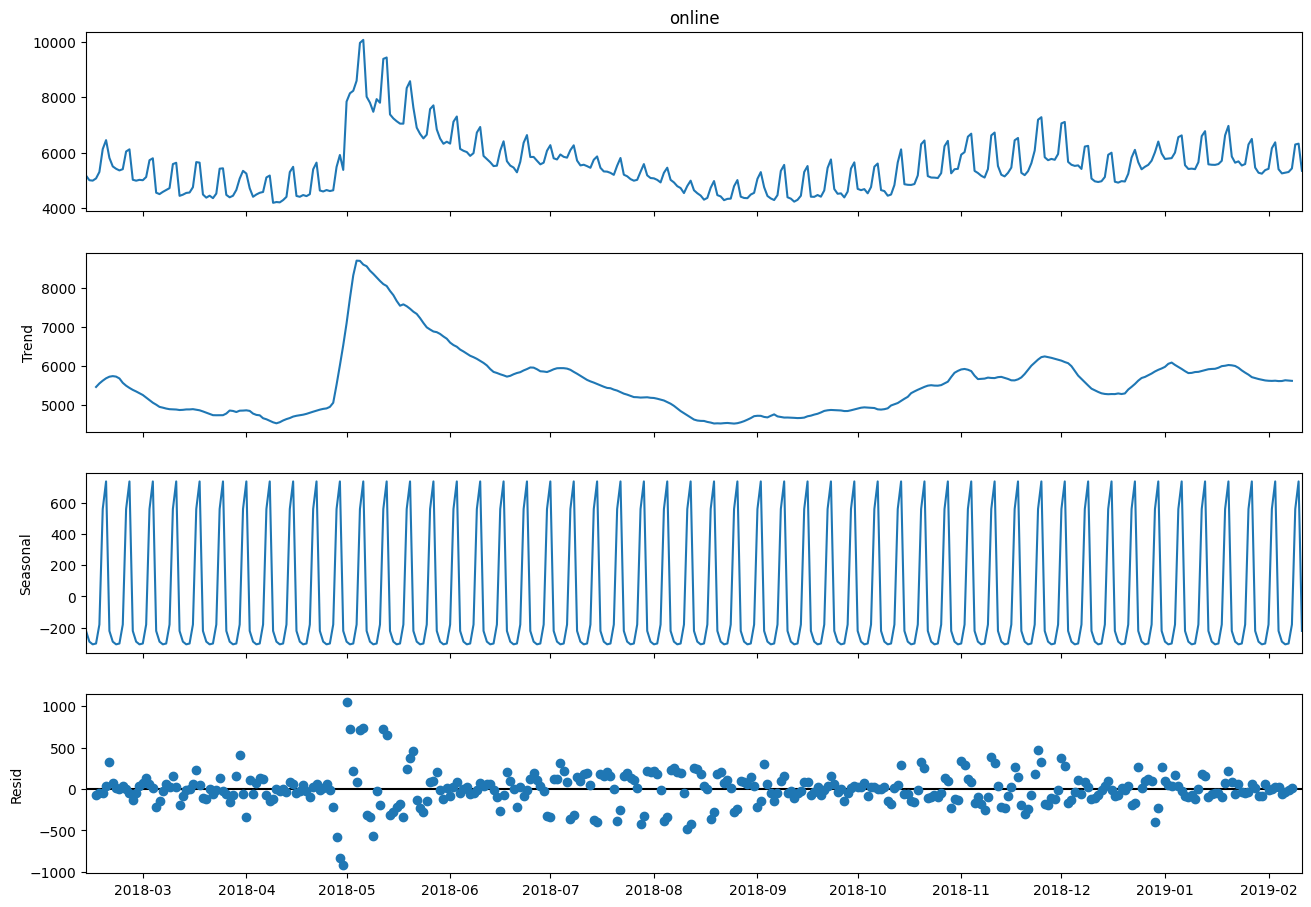

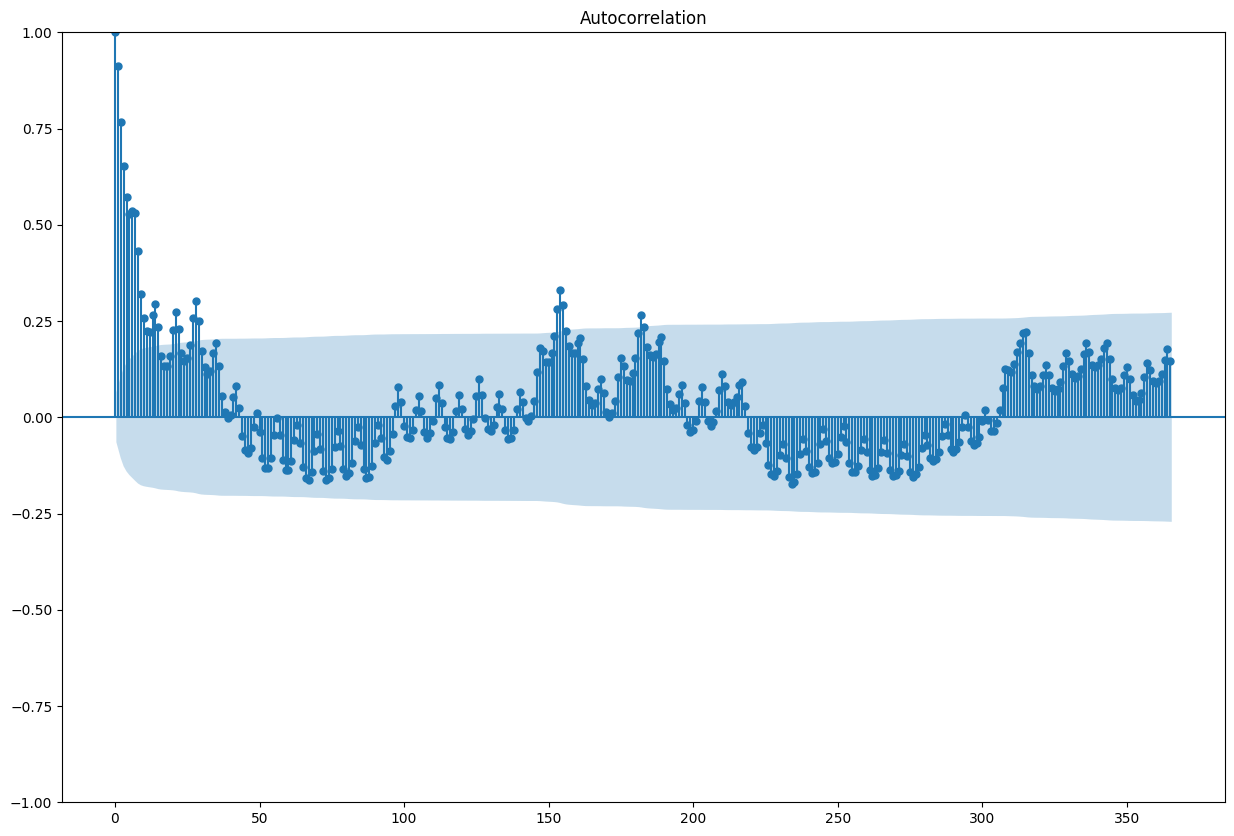

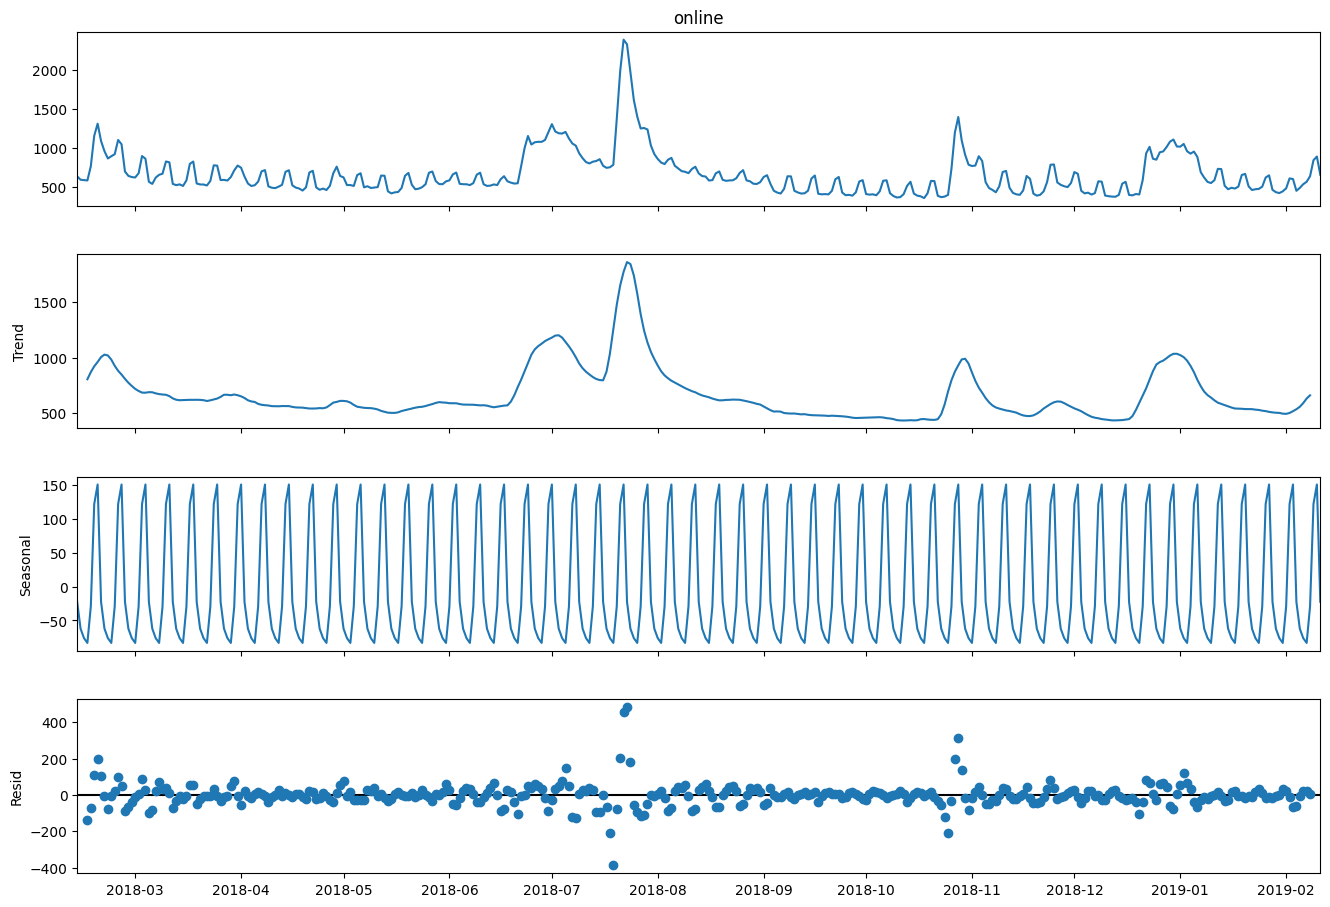

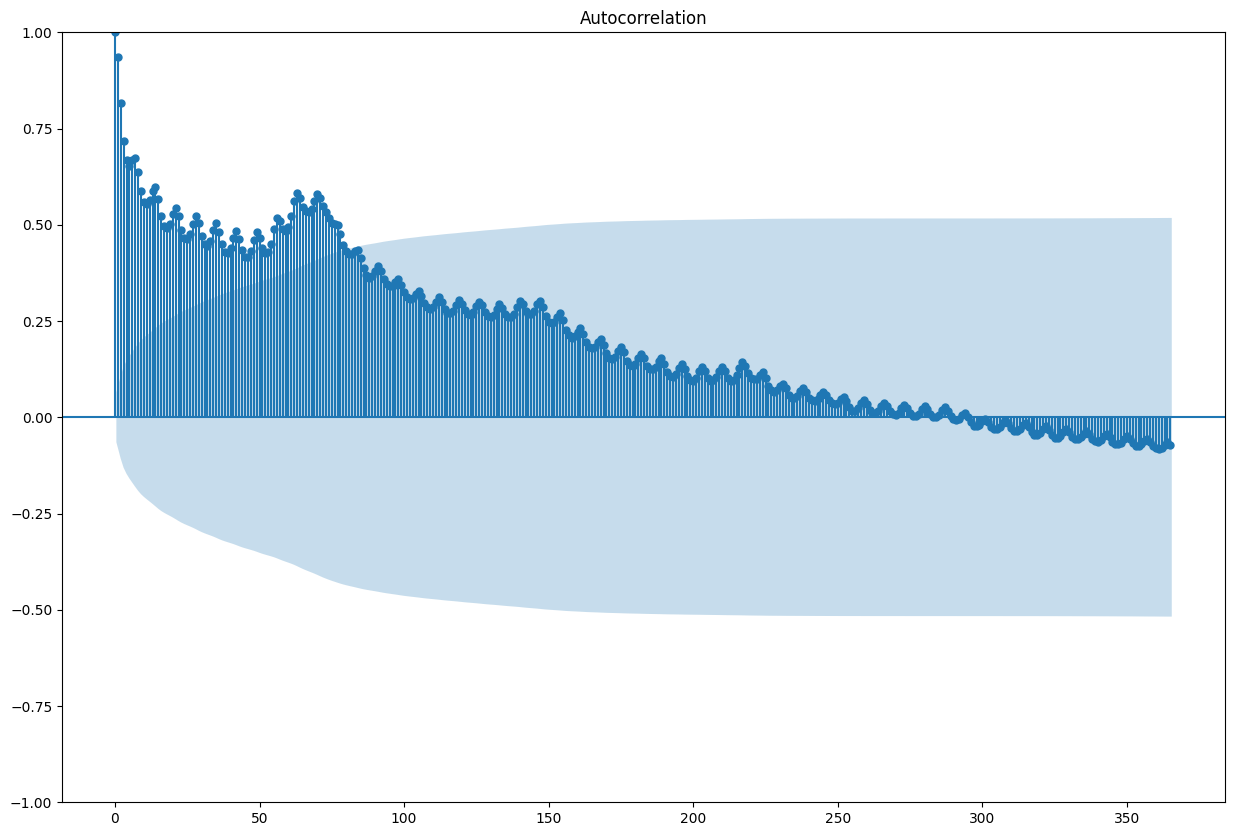

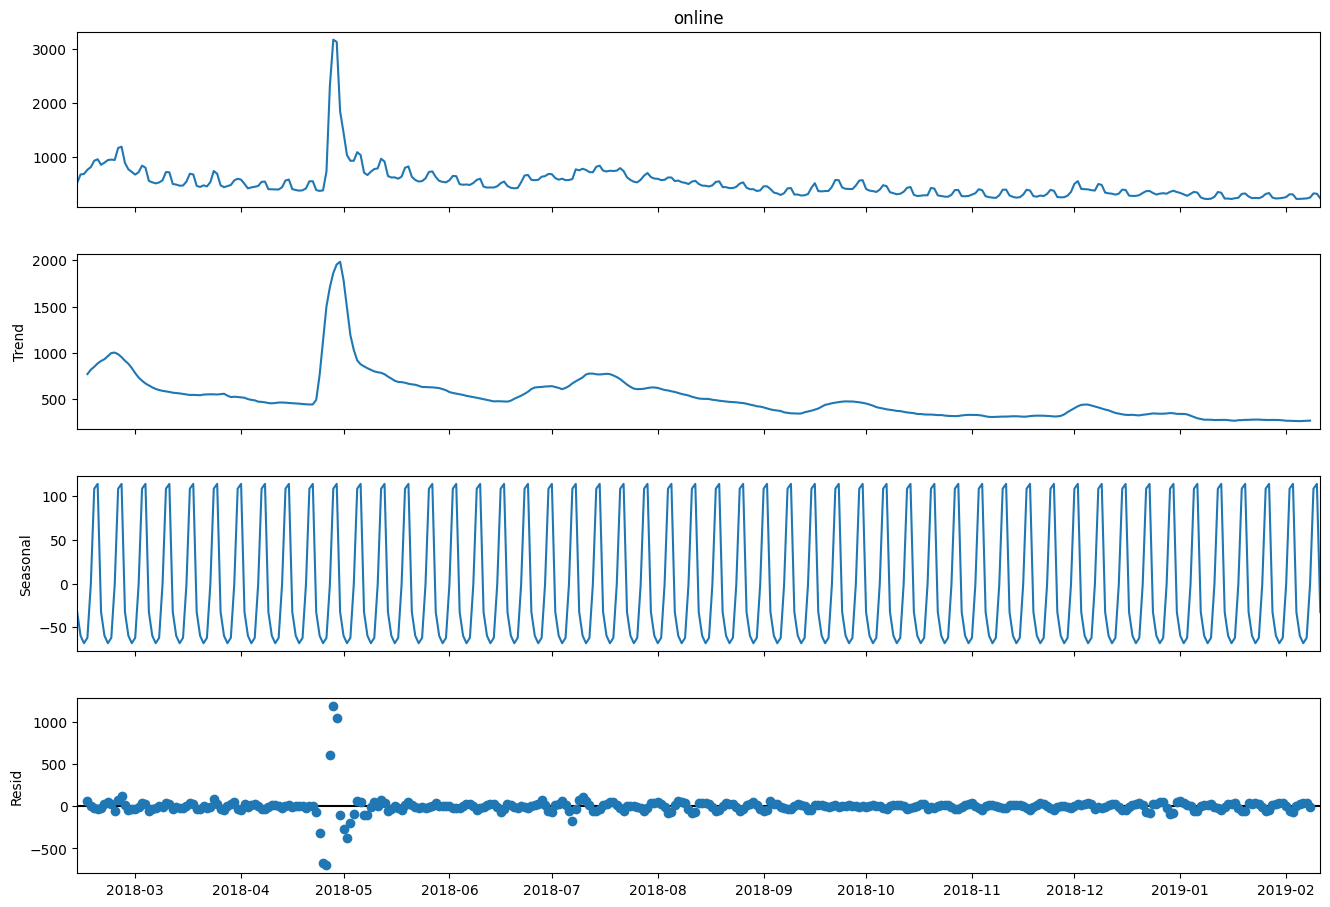

In [8]:
import random
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf


MIDDLE_BELOW_THRESHOLD = 250
MIDDLE_ABOVE_THRESHOLD = 1000
MONTHS_BEFORE = 1

popular_game_id = random.choice([app_id for app_id, data in time_series_data.items() if data["test"]["online"].mean() > MIDDLE_ABOVE_THRESHOLD])
semi_popular_game_id = random.choice([app_id for app_id, data in time_series_data.items() if MIDDLE_BELOW_THRESHOLD <= data["test"]["online"].mean() <= MIDDLE_ABOVE_THRESHOLD])
unpopular_game_id = random.choice([app_id for app_id, data in time_series_data.items() if data["test"]["online"].mean() < MIDDLE_BELOW_THRESHOLD])

for game_id in [popular_game_id, semi_popular_game_id, unpopular_game_id]:
    fig, ax = plt.subplots(figsize=(15, 10))
    plot_acf(time_series_data[game_id]["all"]["online"], ax=ax, lags=365)
    
    decomposition = smt.seasonal_decompose(time_series_data[game_id]["all"]["online"].iloc[:365])

    fig = decomposition.plot()
    fig.set_size_inches(15, 10)

Compare sarima vs sarimax

In [ ]:
import random
from pmdarima import auto_arima


NUMBER_OF_APPS = 20

app_ids = list(time_series_data.keys())
random.shuffle(app_ids)

total_mape_sarima = 0
total_mape_sarimax = 0

for app_id in app_ids[:NUMBER_OF_APPS]:
    train_data = time_series_data[app_id]["train"]
    test_data = time_series_data[app_id]["test"]

    sarima = auto_arima(train_data[target], m=7)
    pred = sarima.predict(LAG)

    mape = mean_absolute_percentage_error(test_data[target], pred) * 100
    total_mape_sarima += mape

    sarimax = auto_arima(train_data[target], train_data[non_constants_features], m=7)
    pred = sarimax.predict(LAG, test_data[non_constants_features])

    mape = mean_absolute_percentage_error(test_data[target], pred) * 100
    total_mape_sarimax += mape

print(f"SARIMA MAPE: {total_mape_sarima / NUMBER_OF_APPS}")
print(f"SARIMAX MAPE: {total_mape_sarimax / NUMBER_OF_APPS}")

c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: Futur

SARIMA MAPE: 21.89749503226597
SARIMAX MAPE: 25.972541268454304


c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Plot best methods for popular, unpopular and semi-popular game.

c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: Futur

Popular Game Predictions
SARIMA MAPE: 17.408320272321635
SARIMAX MAPE: 14.557665000188388


c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: Futur

Semi-Popular Game Predictions
SARIMA MAPE: 72.39276412858739
SARIMAX MAPE: 56.45650741593736


c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Desktop\Інститут\Аналіз даних в інформаційних системах\2 year\2 semester\Інше\Курсова\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: Futur

Unpopular Game Predictions
SARIMA MAPE: 67.01232066690667
SARIMAX MAPE: 19.015758336011608


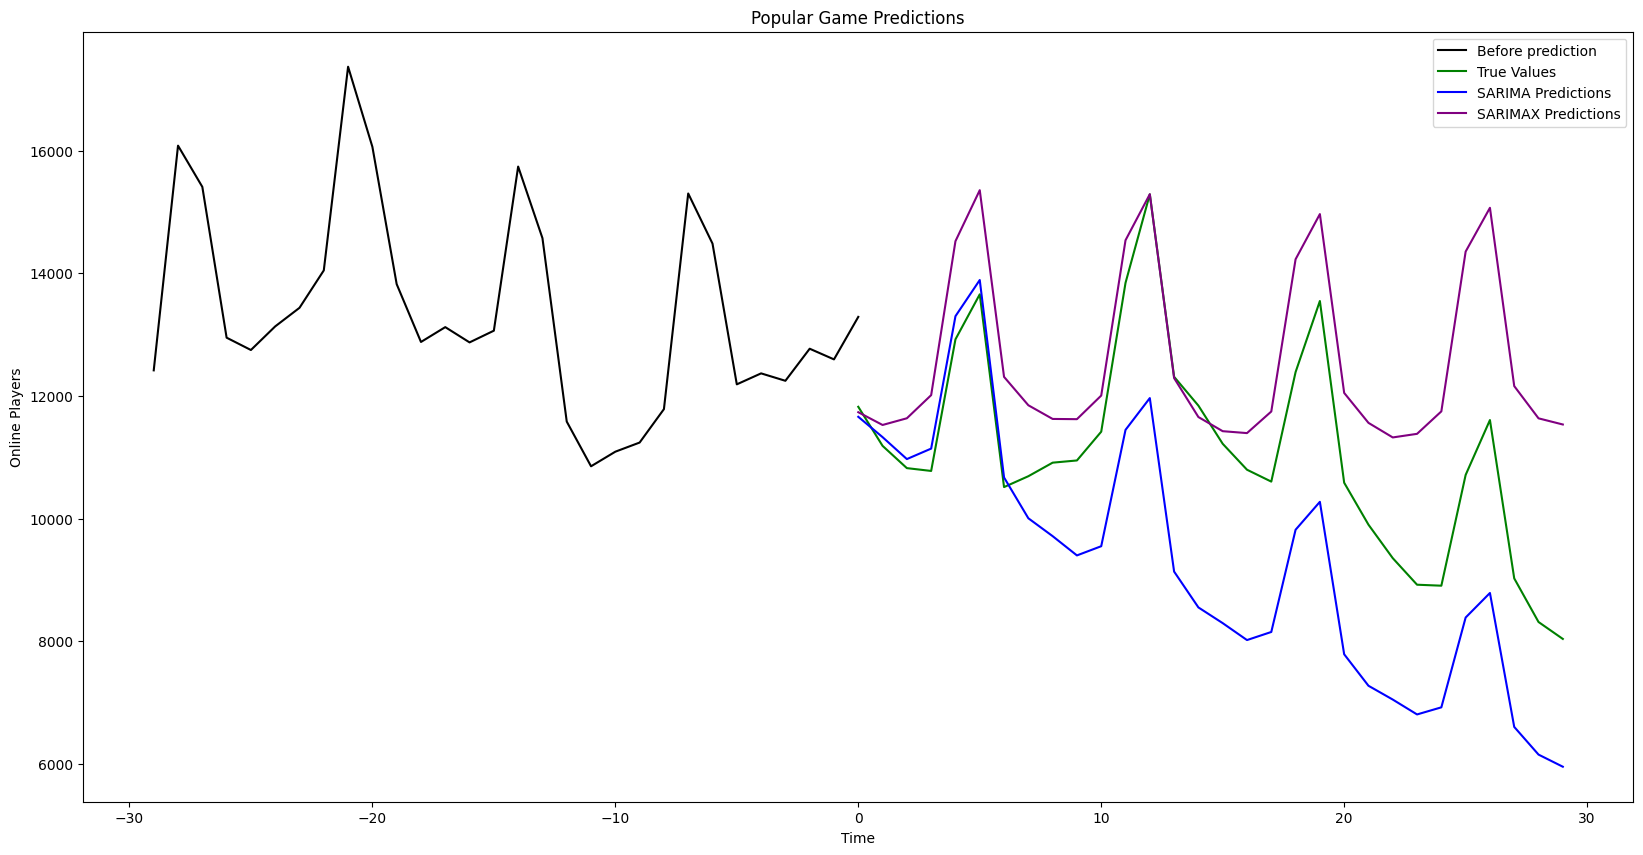

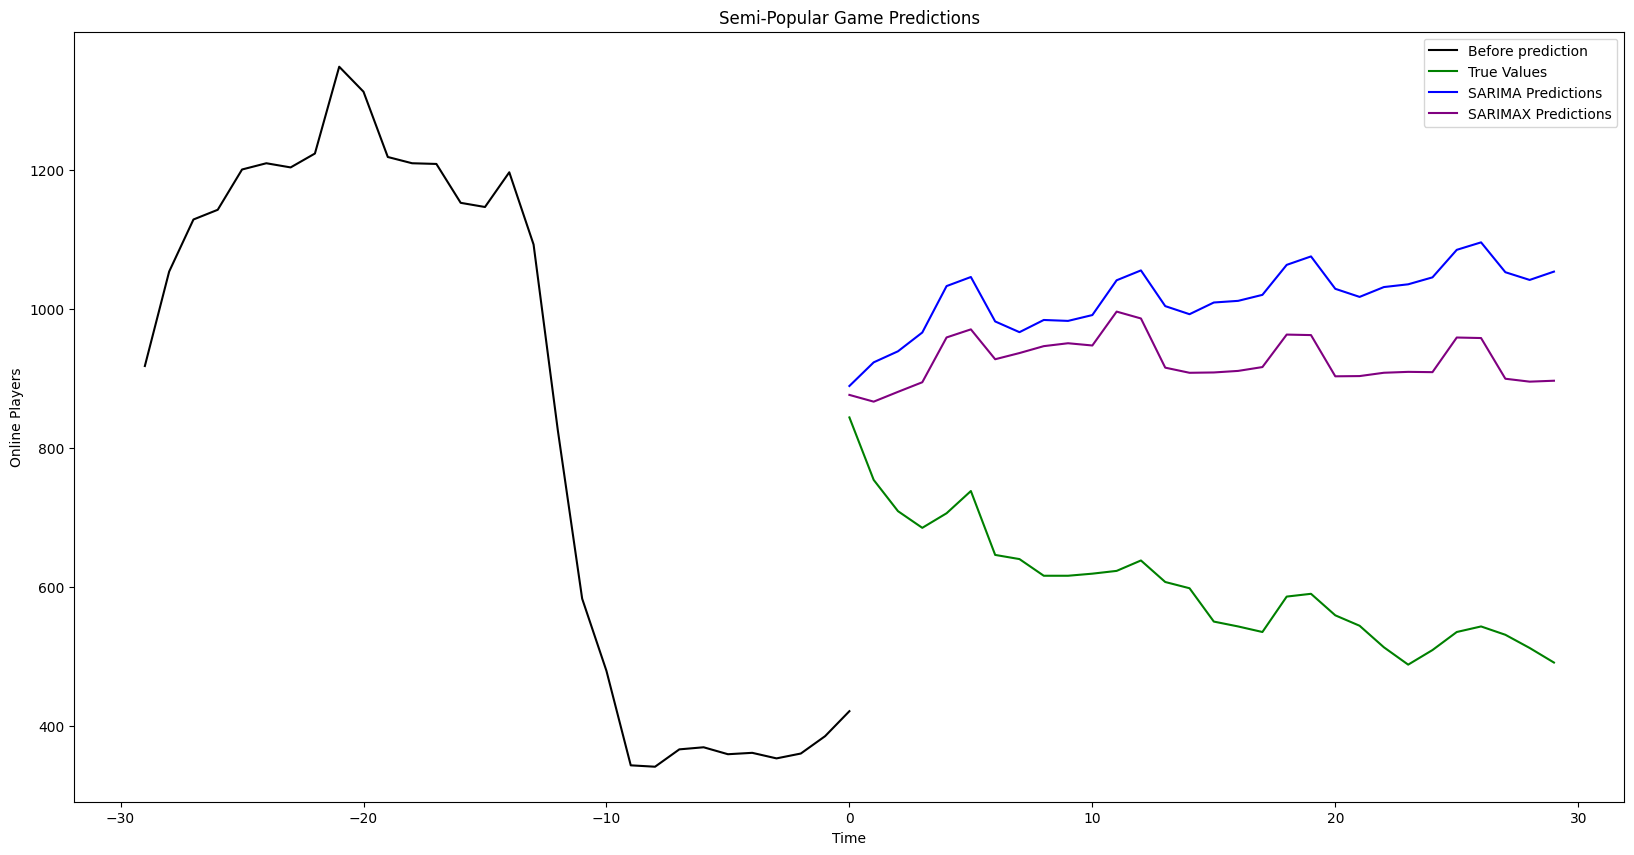

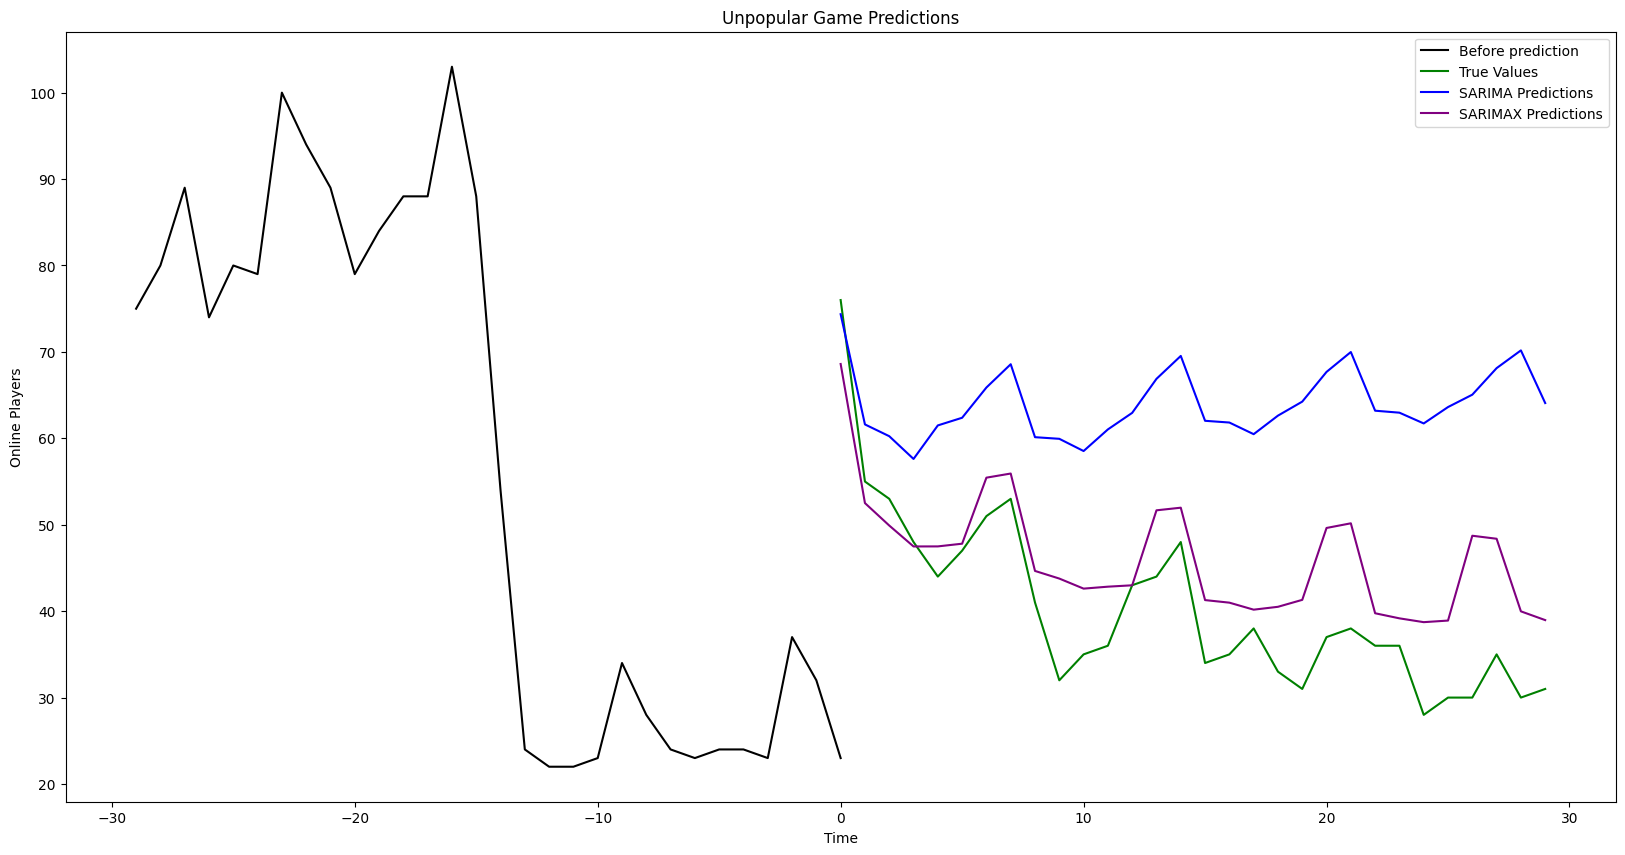

In [32]:
import random


popular_game_id = random.choice([app_id for app_id, data in time_series_data.items() if data["test"]["online"].mean() > MIDDLE_ABOVE_THRESHOLD])
semi_popular_game_id = random.choice([app_id for app_id, data in time_series_data.items() if MIDDLE_BELOW_THRESHOLD <= data["test"]["online"].mean() <= MIDDLE_ABOVE_THRESHOLD])
unpopular_game_id = random.choice([app_id for app_id, data in time_series_data.items() if data["test"]["online"].mean() < MIDDLE_BELOW_THRESHOLD])

def plot_predictions(game_id, title):
    X_game_test = dummy_df[dummy_df["app_id"] == game_id][features].iloc[-LAG:]
    y_game_test = dummy_df[dummy_df["app_id"] == game_id][target].iloc[-LAG:]
    y_game_before_test = dummy_df[dummy_df["app_id"] == game_id][target].iloc[-LAG*(MONTHS_BEFORE+1):-LAG]

    train_data = time_series_data[game_id]["train"]

    sarima = auto_arima(train_data[target], m=7)
    sarimax = auto_arima(train_data[target], train_data[non_constants_features], m=7)

    y_game_sarima_pred = sarima.predict(LAG)
    y_game_sarimax_pred = sarimax.predict(LAG, X_game_test[non_constants_features])

    x_values_before_test = [-i for i in range(LAG*MONTHS_BEFORE)]
    x_values_test = [i for i in range(LAG)]

    plt.figure(figsize=(20, 10))
    plt.plot(x_values_before_test, y_game_before_test.values, label="Before prediction", color='black')
    plt.plot(x_values_test, y_game_test.values, label="True Values", color='green')
    plt.plot(x_values_test, y_game_sarima_pred, label="SARIMA Predictions", color='blue')
    plt.plot(x_values_test, y_game_sarimax_pred, label="SARIMAX Predictions", color='purple')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Online Players")
    plt.legend()

    print(title)
    print("SARIMA MAPE:", mean_absolute_percentage_error(y_game_test, y_game_sarima_pred) * 100)
    print("SARIMAX MAPE:", mean_absolute_percentage_error(y_game_test, y_game_sarimax_pred) * 100)

plot_predictions(popular_game_id, "Popular Game Predictions")
plot_predictions(semi_popular_game_id, "Semi-Popular Game Predictions")
plot_predictions(unpopular_game_id, "Unpopular Game Predictions")